## Audio fingerprinting
In this lab, you will practice with the core parts of the audio fingerprinting algorithm presented in http://www.ismir2002.ismir.net/proceedings/02-FP04-2.pdf.
You will see how to fingerprint a song, and then will index a collection of about 100 songs.
You will then have to implement a song retrieval algorithm employing these fingerprints, and match a number of 'unknown' song excerpts to the collection.

## What to hand in

We give you five 'unknown' excerpts. Your task is to employ the fingerprinting algorithm to identify to what files in your indexed dataset these excerpts correspond.

Please submit a text file named [studentNumberMember1_studentNumberMember2.txt] through https://www.dropbox.com/request/NRmtdN5mbt6jMNuYEMwI with five lines of text, one for each excerpt.

Each line should have the format "<code>excerpt_file_name matched_file_name_in_your_indexed_dataset</code>". The two filenames on each line are to be separated by a space.

For example, a line could look like "<code>excerpt-A.mp3 112233445.mp3</code>". 

## Getting started
As usual, we first import relevant libraries.

In [30]:
import numpy as np

import librosa

from cvtools import ipynb_show_matrix
from datasets import CS4065_Dataset

%matplotlib inline

import IPython

We now fetch and load the dataset.

In [31]:
songretrieval_dataset = CS4065_Dataset.get_songretrieval_subset()
songretrieval_dataset_size = len(songretrieval_dataset)
print 'number of songs: %d' % songretrieval_dataset_size

number of songs: 97


Now, let's have a look at a random audio file.

In [33]:
audio_file_index = np.random.randint(0, songretrieval_dataset_size)
audio_file_keys = songretrieval_dataset.keys()
audio_file_key = audio_file_keys[audio_file_index]  # File name.
audio_file_path = songretrieval_dataset[audio_file_key]  # File path.
print audio_file_path
print 'random audio file: <%s>' % audio_file_key

signal, sample_rate = librosa.core.load(audio_file_path)
assert len(np.shape(signal)) == 1, 'single channel expected'
assert sample_rate == 22050, 'unexpected sample rate found'
print 'number of samples: %d' % len(signal)
print 'sample rate: %d' % sample_rate
print 'duration: %.1f seconds' % (float(len(signal)) / float(sample_rate))

/home/student/data/cs4065/songretrieval_subset/102102827.mp3
random audio file: <102102827.mp3>
number of samples: 331247
sample rate: 22050
duration: 15.0 seconds


We also can render an audio player to listen to the file.

In [34]:
IPython.display.display(IPython.display.Audio(audio_file_path))

## Fingerprint extraction
Given a music signal, we want to summarize the auditory information that it contains. The summary has to be in the form of a collection of *fingerprints*. The computed fingerprints are meant to be used both at the *indexing* and *retrieval* step.

When indexing, the fingerprints are stored in a data structure that is efficient for searching. This is because at the retrieval step, the fingerprints extracted from the excerpt to be recognized have to be matched against the indexed ones. A function that analyzes the found matches will finally determine whether the given excerpt corresponds to one of the indexed songs.

## Pipeline
Assuming that the input signal has a single channel (i.e., mono) and its sample rate is 22050 Hz, fingerpints are extracted using the following pipeline:
 1. Apply a short-time Fourier Transform (STFT) (no overlap, 512 samples per frame) to retrieve the frequencies present in the signal
 2. Compute the magnitude spectrum of the signal, representing the amount of energy for each of the frequencies
 3. Applying the perceptual Bark scale (17 bands), compute the magnitude per band
 4. Compute first-order derivatives in the frequency and time domain
 5. Apply binarization to efficiently encode the derivatives.

We will assist you in building the steps to this pipeline: see the blocks below. Upon setting up the pipeline, you will be asked to use it for indexing and retrieval.

### Short-time Fourier Transform (STFT)
We represent the input signal in the frequency domain over time. To this end, we divide the signal in non-overlapping frames of 512 samples each. For each frame, we compute the FFT. The output is a matrix of spectral coefficients.

In [35]:
def compute_stft(signal, frame_size = 512):
    print 'computing STFT'
    signal = np.array(signal)
    assert len(np.shape(signal)) == 1, 'single channel expected'
    number_of_samples = len(signal)
    number_of_full_frames = int(np.floor(float(number_of_samples) / float(frame_size)))
    print ' - number of full frames: %d' % number_of_full_frames

    # Remove last frame (if not full).
    print ' - original number of samples: %d' % number_of_samples
    number_of_samples = number_of_full_frames * frame_size
    print ' - number of retained samples: %d' % number_of_samples
    signal = signal[:number_of_samples]
    
    # Split into frames (reshape to a matrix that has one row per frame).
    signal_frames = np.reshape(signal, (number_of_full_frames, frame_size))

    # Compute frame-wise FFT.
    signal_stft = np.fft.fft(signal_frames).T
    print ' - STFT matrix size: %d x %d' % np.shape(signal_stft)

    return signal_stft

In [36]:
# We now use this newly created function to compute the STFT
signal_stft = compute_stft(signal)

# Each row in signal_stft, that is a frequency bin, is associated to a frequency.
# We can use numpy to get the frequencies of each bin.
number_of_frequency_bins = np.shape(signal_stft)[0]
frequencies = np.fft.fftfreq(number_of_frequency_bins, d=1.0 / float(sample_rate))

# If we look at the first bin, we see that:
# - the frequency is zero,
# - all the values are real (the imaginary part is zero).
print
print 'first bin frequency: %.1f hz' % frequencies[0]
print signal_stft[0, :10]  # We only show the first 10 frames (but it holds for all the frames).

computing STFT
 - number of full frames: 646
 - original number of samples: 331247
 - number of retained samples: 330752
 - STFT matrix size: 512 x 646

first bin frequency: 0.0 hz
[ -5.11340332+0.j   6.37344360+0.j -17.77908325+0.j   6.02865601+0.j
  -2.73046875+0.j  14.81860352+0.j   5.33935547+0.j -10.27041626+0.j
  -6.92996216+0.j   2.32086182+0.j]


### Magnitude spectrum
For each frame, we have 512 frequency domain coefficients. The first half of each vector of spectral coefficients is the conjugate of the second half. We retain only the first half and compute the magnitudes.

In [37]:
# First step: compute the magnitude spectrum.

def compute_magnitude_spectrum(signal_stft):
    # Throw away redundant coefficients.
    signal_stft = signal_stft[:257, :]
    
    # Flip matrix in order to have the highest frequency associated to
    # the lowest row indexes (useful for visualization).
    signal_stft = np.flipud(signal_stft)

    # Compute the magnitude: module of each coefficient (note that we have complex coefficients).
    return np.log(np.real(signal_stft * np.conjugate(signal_stft)))


magnitude spectrum matrix: 257 x 646


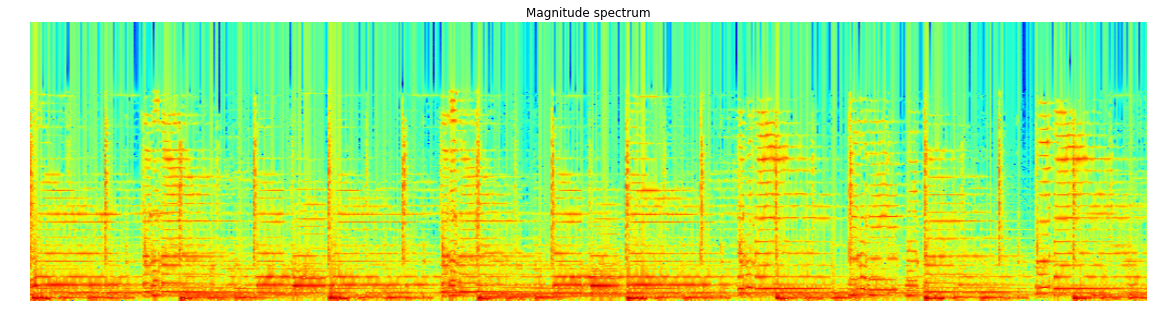

In [38]:
# Compute the magnitude spectrum
magnitude_spectrum = compute_magnitude_spectrum(signal_stft)
print 'magnitude spectrum matrix: %d x %d' % np.shape(magnitude_spectrum)
ipynb_show_matrix(magnitude_spectrum, 'Magnitude spectrum', figsize=(20, 5))

### Band magnitudes
We sum up the individual magnitudes per band using 17 given perceptual bands. The latter have been pre-determined using the Bark scale (see https://en.wikipedia.org/wiki/Bark_scale).

In [39]:
# Bark scale band boundaries.
# Each band includes the indexes in the interval [index0, index1)
# where index0 and index1 are adjacent values.
BARK_SCALE_BANDS = [0, 2, 4, 7, 10, 13, 17, 21, 26, 32, 40, 50, 62, 79, 104, 136, 184, 257]

def compute_band_magnitudes(magnitude_spectrum):
    number_of_frames = np.shape(magnitude_spectrum)[1]
    number_of_bands = len(BARK_SCALE_BANDS) - 1
    band_magnitudes = np.zeros((number_of_bands, number_of_frames))
    for band_index in range(number_of_bands):
        index0 = BARK_SCALE_BANDS[band_index]
        index1 = BARK_SCALE_BANDS[band_index + 1]
        band_magnitudes[band_index, :] = np.sum(magnitude_spectrum[index0:index1, :], axis=0)

    return band_magnitudes

band magnitudes matrix: 17 x 646


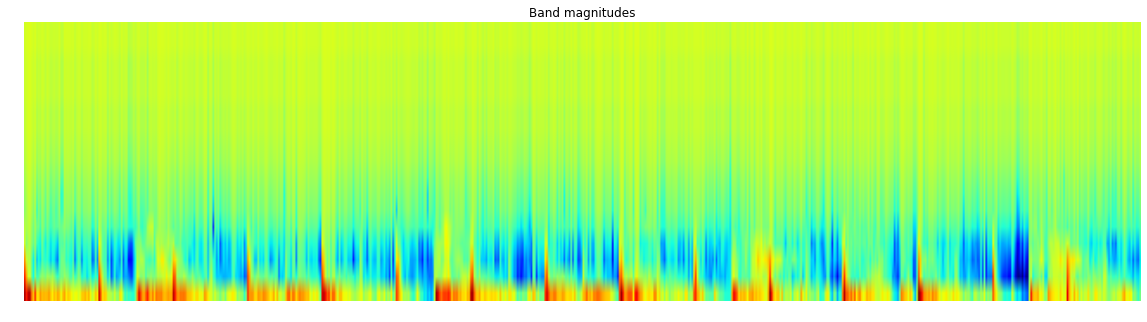

In [40]:
# We now compute the band magnitudes
band_magnitudes = compute_band_magnitudes(magnitude_spectrum)
print 'band magnitudes matrix: %d x %d' % np.shape(band_magnitudes)
ipynb_show_matrix(band_magnitudes, 'Band magnitudes', figsize=(20, 5))

### Frequency and time domain derivatives
The absolute magnitude values computed above are not invariant to power level and additive noise. However, if we consider local differences along both time and frequency, we may expect to observe similar values when an excerpt has to be recognized.

In [41]:
def compute_band_magnitudes_derivatives(band_magnitudes):    
    # Differences between neighboring bands.
    diff_frequency = band_magnitudes[1:, :] - band_magnitudes[:-1, :]

    # Differences between neighboring frames.
    diff_time = diff_frequency[:, 1:] - diff_frequency[:, :-1]

    number_of_bands, number_of_frames = np.shape(band_magnitudes)
    assert np.shape(diff_time) == (number_of_bands - 1, number_of_frames - 1)
    return diff_time

band magnitudes derivatives matrix: 16 x 645
[[ -7.88150346e-04   5.47883848e-03  -6.03297315e-03 ...,   2.56253936e-02
   -3.53072009e-02   2.02747915e-02]
 [  1.83501163e+00   1.50557212e+00   2.80274729e-01 ...,  -2.08167320e+00
   -2.42135116e-01   2.31533950e+00]
 [ -2.43249250e-02   4.58904238e-03  -8.79533915e-04 ...,  -7.41946558e-02
   -4.15859109e-02   1.29666721e-01]
 ..., 
 [ -3.72528918e+01  -3.76431294e+01  -2.96025574e+00 ...,   3.64434683e+00
   -4.39833240e+00   1.14525629e+01]
 [  6.13649763e+00  -5.65645608e+01   1.21809233e+01 ...,   2.19734007e+01
    6.69783991e+00  -3.91726966e+01]
 [  3.50793374e+01   1.05425200e+02  -1.53227762e+01 ...,  -1.68324799e+01
   -1.88997205e+01   1.14949784e+01]]


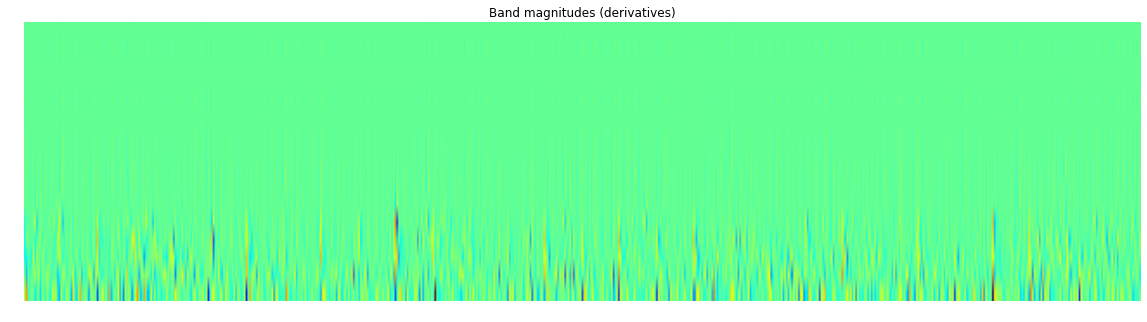

In [42]:
# We now take the derivatives over frequency and time
band_magnitudes_diff = compute_band_magnitudes_derivatives(band_magnitudes)
print 'band magnitudes derivatives matrix: %d x %d' % np.shape(band_magnitudes_diff)
ipynb_show_matrix(band_magnitudes_diff, 'Band magnitudes (derivatives)', figsize=(20, 5))
print band_magnitudes_diff

### Binarization
Finally, we further improve the robustness of the fingeprints (while reducing the amount of encoded data), by binarizing the matrix computed using <code>compute_band_magnitudes_derivatives()</code>. We simply set a zero when a value is negative, and one otherwise.

In [43]:
def binarize(band_magnitudes_diff):
    binarized = np.ones(np.shape(band_magnitudes_diff), dtype=np.uint8)
    binarized[band_magnitudes_diff < 0.0] = 0
    return binarized

(16, 645)
16


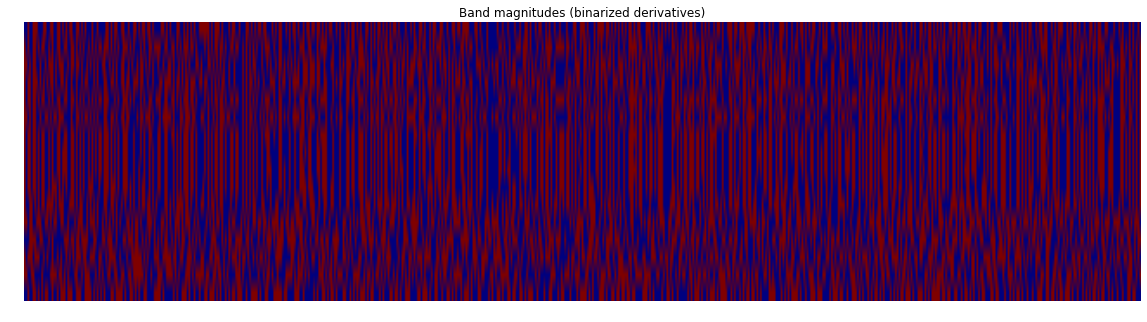

In [50]:
# computed the binarization
band_magnitudes_diff_binarized = binarize(band_magnitudes_diff)
ipynb_show_matrix(band_magnitudes_diff_binarized, 'Band magnitudes (binarized derivatives)', figsize=(20, 5))
print band_magnitudes_diff_binarized.shape
print band_magnitudes_diff_binarized.shape[0]

## Question to you: index the collection of songs
We are now ready to index the given songs. You have to iterate over the collection (see <code>songretrieval_dataset</code> above) and use the pipeline implemented above to produce a matrix of binarized band magnitude differences for each song. Store each matrix as numpy file using <code>np.save()</code> (see http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.save.html). You can store the files in the same directory where the MP3 files are (e.g., use the same file name and use .npy as extension).

In [55]:
# TODO: put your indexing code here.
for song in songretrieval_dataset.keys():
    print songretrieval_dataset[song][0:len(songretrieval_dataset[song])-4]
    np_name_to_save=songretrieval_dataset[song][0:len(songretrieval_dataset[song])-4]
    signal, sample_rate = librosa.core.load(songretrieval_dataset[song])
    signal_stft = compute_stft(signal)
    magnitude_spectrum = compute_magnitude_spectrum(signal_stft)
    band_magnitudes = compute_band_magnitudes(magnitude_spectrum)
    band_magnitudes_diff = compute_band_magnitudes_derivatives(band_magnitudes)
    band_magnitudes_diff_binarized = binarize(band_magnitudes_diff)
#     ipynb_show_matrix(band_magnitudes_diff_binarized, 'Band magnitudes (binarized derivatives)', figsize=(20, 5))
#     print band_magnitudes_diff_binarized.shape
    np.save(np_name_to_save,band_magnitudes_diff_binarized)
    print(np.load(np_name_to_save+".npy"))


/home/student/data/cs4065/songretrieval_subset/101446168
computing STFT
 - number of full frames: 646
 - original number of samples: 331247
 - number of retained samples: 330752
 - STFT matrix size: 512 x 646
[[1 0 0 ..., 1 0 0]
 [0 1 1 ..., 1 0 0]
 [1 0 0 ..., 0 1 0]
 ..., 
 [0 0 1 ..., 1 0 1]
 [0 1 1 ..., 1 0 1]
 [0 1 1 ..., 0 1 0]]
/home/student/data/cs4065/songretrieval_subset/101657006
computing STFT
 - number of full frames: 646
 - original number of samples: 331247
 - number of retained samples: 330752
 - STFT matrix size: 512 x 646
[[1 0 0 ..., 1 0 1]
 [0 1 0 ..., 0 0 0]
 [0 1 0 ..., 1 0 1]
 ..., 
 [0 1 1 ..., 1 0 0]
 [0 1 0 ..., 0 0 0]
 [0 0 1 ..., 0 0 1]]
/home/student/data/cs4065/songretrieval_subset/102150277
computing STFT
 - number of full frames: 646
 - original number of samples: 331247
 - number of retained samples: 330752
 - STFT matrix size: 512 x 646
[[0 1 0 ..., 1 1 0]
 [1 0 1 ..., 1 1 0]
 [0 0 1 ..., 0 1 1]
 ..., 
 [0 0 0 ..., 0 1 0]
 [1 0 0 ..., 0 1 1]
 [0 1 0 ..

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log


[[0 1 0 ..., 1 1 0]
 [1 0 0 ..., 0 1 0]
 [1 0 1 ..., 1 0 1]
 ..., 
 [0 0 0 ..., 0 0 1]
 [0 0 1 ..., 0 1 0]
 [0 1 1 ..., 1 1 0]]
/home/student/data/cs4065/songretrieval_subset/101114894
computing STFT
 - number of full frames: 646
 - original number of samples: 331247
 - number of retained samples: 330752
 - STFT matrix size: 512 x 646
[[1 0 1 ..., 1 1 0]
 [1 1 1 ..., 0 0 1]
 [0 0 1 ..., 0 0 1]
 ..., 
 [1 0 1 ..., 0 1 0]
 [1 0 1 ..., 0 0 1]
 [1 0 0 ..., 1 1 0]]
/home/student/data/cs4065/songretrieval_subset/100328332
computing STFT
 - number of full frames: 646
 - original number of samples: 331247
 - number of retained samples: 330752
 - STFT matrix size: 512 x 646
[[1 1 1 ..., 0 1 1]
 [1 1 0 ..., 1 1 0]
 [0 1 1 ..., 0 1 1]
 ..., 
 [1 1 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [1 1 0 ..., 0 1 1]]
/home/student/data/cs4065/songretrieval_subset/101952711
computing STFT
 - number of full frames: 646
 - original number of samples: 331247
 - number of retained samples: 330752
 - STFT matrix size:

KeyboardInterrupt: 

## Question to you: recognize an excerpt
Assume that you are given 15 seconds long excerpts to recognize. As done at the indexing step, you have to extract the matrix of binarized magnitude differences computed by <code>binarize</code>. Then, you compare this matrix against *all* the matrices that you have stored as .npy files at the indexing step.

The result of each comparison has to be a scalar value named *Bit Error Rate* (BER).
The BER is simply computed as the number of differences between two binarized matrices (one belonging to the query excerpts and one to a candidate match) divided by the number of bits (i.e., the matrix size). When the query excerpt is shorter in duration than an indexed song, slice the indexed matrix accordingly.

In [56]:
# TODO: put your code for recognizing an excerpt here.
# It is advisable to also create a helper function for computing the Bit Error Rate between two binarized matrices.

def bit_error_rate(binarized_1,binarized_2):
    if binarized_1.shape[1]<binarized_2.shape[1]:
        binarized_2=binarized_2[:,:binarized_1.shape[1]]
    elif binarized_1.shape[1]>binarized_2.shape[1]:
        binarized_1=binarized_1[:,:binarized_2.shape[1]]
    temp_diff=np.abs(binarized_2-binarized_1)
    diff_num=np.count_nonzero(temp_diff==1)
    return diff_num*1.0/np.prod(binarized_2.shape)

def get_final_matrix(song):
    signal, sample_rate = librosa.core.load(song)
    signal_stft = compute_stft(signal)
    magnitude_spectrum = compute_magnitude_spectrum(signal_stft)
    band_magnitudes = compute_band_magnitudes(magnitude_spectrum)
    band_magnitudes_diff = compute_band_magnitudes_derivatives(band_magnitudes)
    band_magnitudes_diff_binarized = binarize(band_magnitudes_diff)
    return band_magnitudes_diff_binarized
    



# Assignment
We give you five 'unknown' excerpts. Your task is to employ the fingerprinting algorithm to identify to what files in your indexed dataset these excerpts correspond.

Please submit a text file named [studentNumberMember1_studentNumberMember2.txt] through https://www.dropbox.com/request/NRmtdN5mbt6jMNuYEMwI with five lines of text, one for each excerpt.

Each line should have the format "<code>excerpt_file_name matched_file_name_in_your_indexed_dataset</code>". The two filenames on each line are to be separated by a space.

For example, a line could look like "<code>excerpt-A.mp3 112233445.mp3</code>". 

Fetch the 'unknown' query excerpts.

In [52]:
songretrieval_queries = CS4065_Dataset.get_songretrieval_queries()

[notice] fetching <songretrieval_queries> dataset


If you'd like to listen to them, you can render them all in a loop:

In [53]:
for snippet in songretrieval_queries:
    print '%s:' % snippet
    IPython.display.display(IPython.display.Audio(songretrieval_queries[snippet]))

E.mp3:


B.mp3:


A.mp3:


D.mp3:


C.mp3:


In [77]:
store_dict=[]
for snippet in songretrieval_queries:
    smallest_name_error=('',2)
#     print snippet
    temp_song_binary_matrix=get_final_matrix(songretrieval_queries[snippet])
    for song in songretrieval_dataset.keys():
#         print songretrieval_dataset[song]
        temp_string_array=songretrieval_dataset[song].split('/')
        song_name_in_dataset=temp_string_array[len(temp_string_array)-1]
#         print song_name_in_dataset
        np_name_to_load=songretrieval_dataset[song][0:len(songretrieval_dataset[song])-4]+".npy"
        np_matrix_temp = np.load(np_name_to_load)
        temp_error=bit_error_rate(np_matrix_temp,temp_song_binary_matrix)
#         print temp_error
        if temp_error<smallest_name_error[1]:
            smallest_name_error=(song_name_in_dataset,temp_error)
    print snippet, smallest_name_error[0]   
    store_dict.append((snippet, smallest_name_error[0]))
#     break
    

computing STFT
 - number of full frames: 646
 - original number of samples: 331247
 - number of retained samples: 330752
 - STFT matrix size: 512 x 646
E.mp3 101730247.mp3
computing STFT
 - number of full frames: 646
 - original number of samples: 331247
 - number of retained samples: 330752
 - STFT matrix size: 512 x 646
B.mp3 101952711.mp3
computing STFT
 - number of full frames: 646
 - original number of samples: 331247
 - number of retained samples: 330752
 - STFT matrix size: 512 x 646
A.mp3 101480657.mp3
computing STFT
 - number of full frames: 646
 - original number of samples: 331247
 - number of retained samples: 330752
 - STFT matrix size: 512 x 646
D.mp3 101657006.mp3
computing STFT
 - number of full frames: 646
 - original number of samples: 331247
 - number of retained samples: 330752
 - STFT matrix size: 512 x 646
C.mp3 102107298.mp3


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log


In [79]:
for pair in store_dict:
    print pair[0],pair[1]

E.mp3 101730247.mp3
B.mp3 101952711.mp3
A.mp3 101480657.mp3
D.mp3 101657006.mp3
C.mp3 102107298.mp3


Use your code above to fingerprint and match these excerpts to the right songs.